# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt("./datasets/human/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt")
y_train = np.loadtxt("./datasets/human/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt").astype(int)

X_test = np.loadtxt("./datasets/human/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt")
y_test = np.loadtxt("./datasets/human/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt").astype(int)

In [3]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [4]:
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

Определим число уникальных значений меток целевого класса.

In [5]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [6]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [8]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- **65**
- 66
- 193

Ответ: 65

In [9]:
# Минимальное число компонент для 90% дисперсии
n_components_90 = pca.n_components_
print(f"Число компонент для 90% дисперсии: {n_components_90}")
print(f"Объясненная дисперсия: {pca.explained_variance_ratio_.sum():.4f}")

Число компонент для 90% дисперсии: 65
Объясненная дисперсия: 0.9005


**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- **51**
- 56
- 61

Ответ: 51

In [10]:
# Процент дисперсии для первой компоненты
first_pc_variance = pca.explained_variance_ratio_[0] * 100
print(f"Дисперсия первой компоненты: {first_pc_variance:.1f}%")
print(f"Округленное значение: {round(first_pc_variance)}%")

Дисперсия первой компоненты: 50.7%
Округленное значение: 51%


Визуализируйте данные в проекции на первые две главные компоненты.

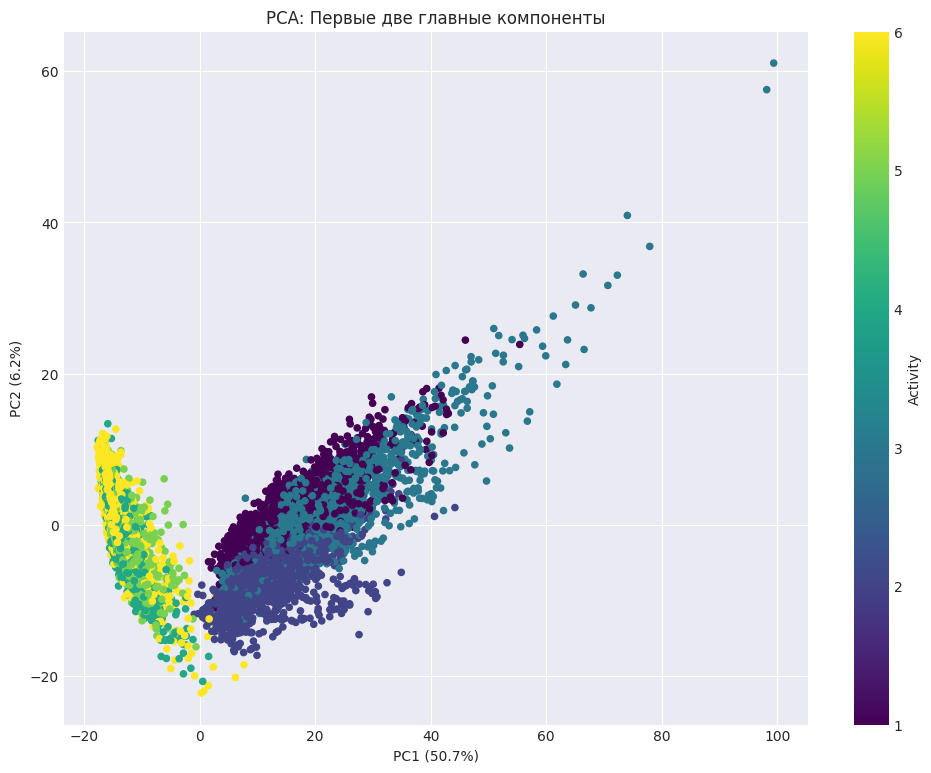

In [11]:
# Визуализация данных на первых двух компонентах
plt.figure(figsize=(12, 9))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.title('PCA: Первые две главные компоненты')
plt.colorbar(label='Activity')
plt.show()

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- **2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)**
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [12]:
# Собственная реализация KMeans
class KMeansCustom:
    def __init__(self, n_clusters, n_init=100, max_iter=300, random_state=None):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = random_state
        self.centroids = None
        self.inertia_ = None
        
    def _init_centroids(self, X, random_state):
        """Инициализация центроид случайным выбором из данных"""
        np.random.seed(random_state)
        indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[indices]
    
    def _assign_clusters(self, X):
        """Присвоение каждой точке ближайшего кластера"""
        distances = np.sqrt(((X[:, np.newaxis] - self.centroids) ** 2).sum(axis=2))
        return np.argmin(distances, axis=1)
    
    def _update_centroids(self, X, labels):
        """Обновление центроид как среднего по точкам кластера"""
        new_centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                new_centroids[k] = cluster_points.mean(axis=0)
            else:
                # Если кластер пустой, оставляем центроиду на месте
                new_centroids[k] = self.centroids[k]
        return new_centroids
    
    def _compute_inertia(self, X, labels):
        """Вычисление инерции - суммы квадратов расстояний до центроид"""
        inertia = 0
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                inertia += ((cluster_points - self.centroids[k]) ** 2).sum()
        return inertia
    
    def fit(self, X):
        """Обучение модели с несколькими запусками"""
        best_inertia = np.inf
        best_centroids = None
        best_labels = None
        
        for i in range(self.n_init):
            seed = self.random_state + i if self.random_state is not None else None
            self.centroids = self._init_centroids(X, seed)
            
            for _ in range(self.max_iter):
                old_centroids = self.centroids.copy()
                labels = self._assign_clusters(X)
                self.centroids = self._update_centroids(X, labels)
                
                # Проверка сходимости
                if np.allclose(old_centroids, self.centroids):
                    break
            
            inertia = self._compute_inertia(X, labels)
            
            if inertia < best_inertia:
                best_inertia = inertia
                best_centroids = self.centroids
                best_labels = labels
        
        self.centroids = best_centroids
        self.inertia_ = best_inertia
        return self
    
    def predict(self, X):
        """Предсказание кластеров для новых данных"""
        return self._assign_clusters(X)
    
    def fit_predict(self, X):
        """Обучение и предсказание"""
        self.fit(X)
        return self.predict(X)

# Собственная реализация KMeans
print("Собственная реализация KMeans")
kmeans_custom = KMeansCustom(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
cluster_labels_custom = kmeans_custom.fit_predict(X_pca)
print(f"Обучение завершено. Метки кластеров: {np.unique(cluster_labels_custom)}")
print(f"Инерция: {kmeans_custom.inertia_:.2f}")

Собственная реализация KMeans
Обучение завершено. Метки кластеров: [0 1 2 3 4 5]
Инерция: 2003577.56
Обучение завершено. Метки кластеров: [0 1 2 3 4 5]
Инерция: 2003577.56


In [13]:
# KMeans кластеризация
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
cluster_labels = kmeans.fit_predict(X_pca)
print(f"KMeans обучена. Метки кластеров: {np.unique(cluster_labels)}")

KMeans обучена. Метки кластеров: [0 1 2 3 4 5]


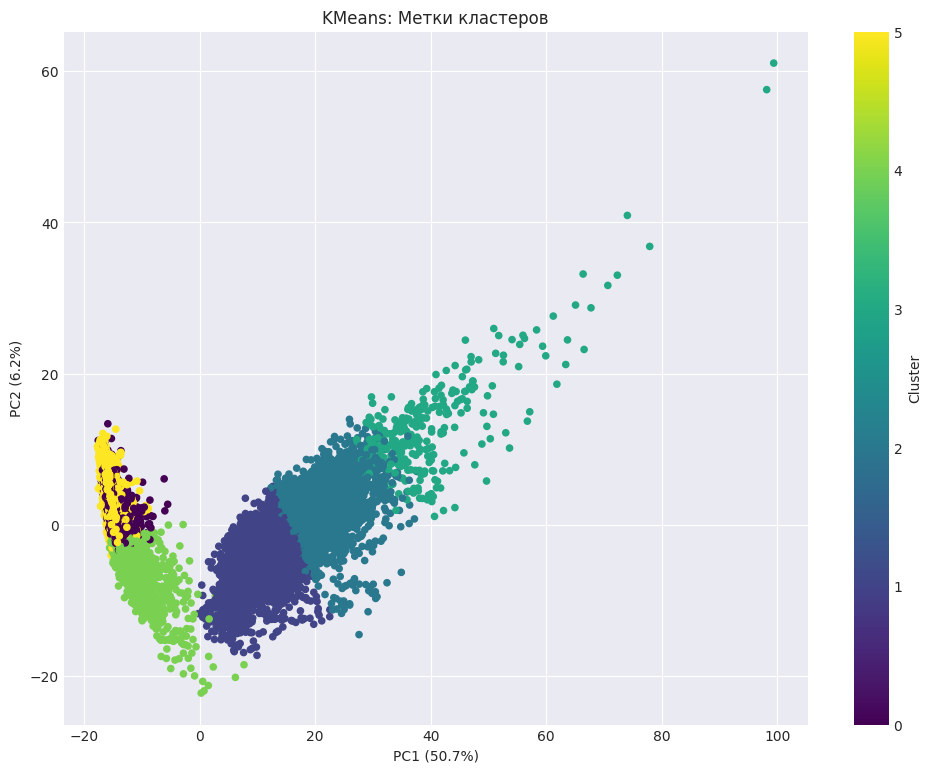

In [14]:
# Визуализация KMeans кластеров
plt.figure(figsize=(12, 9))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20, cmap='viridis')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.title('KMeans: Метки кластеров')
plt.colorbar(label='Cluster')
plt.show()

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [15]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,0,903,741,78,0,0,1722
подъем вверх по лестнице,0,1241,296,5,2,0,1544
спуск по лестнице,0,320,890,196,0,0,1406
сидение,1235,1,0,0,450,91,1777
стояние,1344,0,0,0,562,0,1906
лежание,52,5,0,0,329,1558,1944
все,2631,2470,1927,279,1343,1649,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- **стояние**
- спуск по лестнице
- перечисленные варианты не подходят

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

/tmp/ipykernel_8563/4094459585.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(1, n_classes + 1)):


  0%|          | 0/6 [00:00<?, ?it/s]

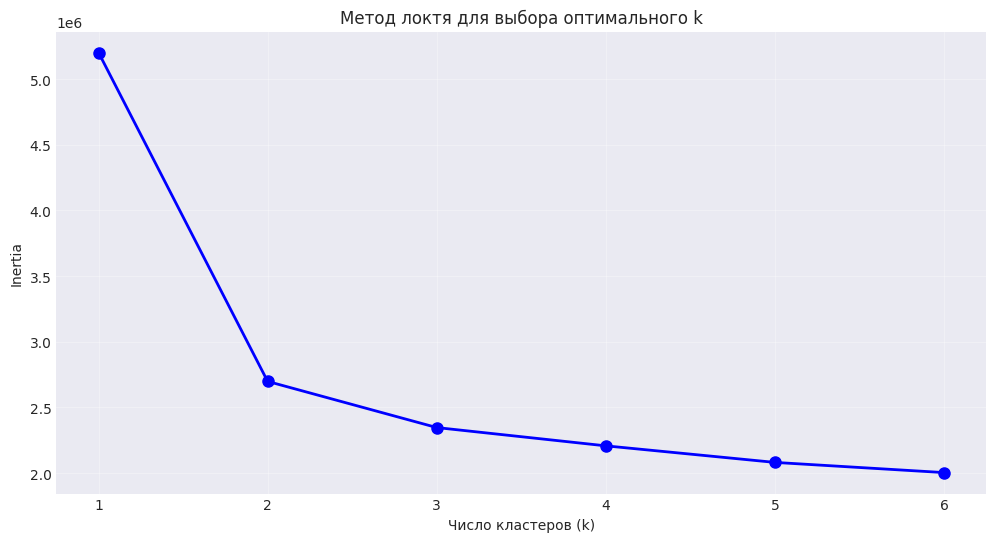

In [16]:
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    km = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    km.fit(X_pca)
    inertia.append(km.inertia_)

plt.figure(figsize=(12, 6))
plt.plot(range(1, n_classes + 1), inertia, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Число кластеров (k)')
plt.ylabel('Inertia')
plt.title('Метод локтя для выбора оптимального k')
plt.grid(True, alpha=0.3)
plt.show()

**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- **2**
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [17]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [18]:
# Adjusted Rand Index для сравнения KMeans и Agglomerative
ari_kmeans = metrics.adjusted_rand_score(y, cluster_labels)
ari_agglomerative = metrics.adjusted_rand_score(y, ag.labels_)

print(f"ARI для KMeans: {ari_kmeans:.4f}")
print(f"ARI для Agg Clustering: {ari_agglomerative:.4f}")

ARI для KMeans: 0.4198
ARI для Agg Clustering: 0.4936


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- **Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering**
- **Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры**
- **В случае случайного разбиения на кластеры ARI будет близок к нулю**

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [19]:
# Настройка LinearSVC с GridSearchCV
scaler_train = StandardScaler()
X_train_scaled = scaler_train.fit_transform(X_train)
X_test_scaled = scaler_train.transform(X_test)
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

X_train_scaled shape: (7352, 561)
X_test_scaled shape: (2947, 561)


In [20]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [21]:
# GridSearchCV для LinearSVC
grid_search = GridSearchCV(svc, svc_params, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)
best_svc = grid_search.best_estimator_

print(f"Лучший параметр C: {grid_search.best_params_['C']}")
print(f"Лучший score на CV: {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/home/kirill/PycharmProjects/ML_labs/.venv/lib64/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/kirill/PycharmProjects/ML_labs/.venv/lib64/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/kirill/PycharmProjects/ML_labs/.venv/lib64/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/kirill/PycharmProjects/ML_labs/.venv/lib64/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/kirill/PycharmProjects/ML_labs/.venv/lib64/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  

Лучший параметр C: 0.1
Лучший score на CV: 0.9381


In [22]:
# Вычисление accuracy на тестовой выборке
test_accuracy = best_svc.score(X_test_scaled, y_test)
print(f"Accuracy на тестовой выборке: {test_accuracy:.4f}")
print(f"Лучший параметр C: {grid_search.best_params_['C']}")

Accuracy на тестовой выборке: 0.9620
Лучший параметр C: 0.1


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- **0.1**
- 1
- 10

In [23]:
y_predicted = best_svc.predict(X_test_scaled)

In [24]:
tabl = pd.crosstab(y_test, y_predicted, margins=True)
tabl.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tabl.columns = tabl.index
tabl

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,442,589,526,2947


**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- **по точности – сидение, по полноте – стояние**

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- **4%**
- 10%
- 20%


In [25]:
# LinearSVC с PCA на обучающей выборке
pca_train = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_pca = pca_train.fit_transform(X_train_scaled)
X_test_pca = pca_train.transform(X_test_scaled)

# GridSearchCV с PCA
grid_search_pca = GridSearchCV(LinearSVC(random_state=RANDOM_STATE), 
                               svc_params, cv=3, n_jobs=-1, verbose=0)
grid_search_pca.fit(X_train_pca, y_train)
best_svc_pca = grid_search_pca.best_estimator_

print(f"=== С PCA ===" )
print(f"Лучший параметр C: {grid_search_pca.best_params_['C']}")
print(f"Лучший score на CV с PCA: {grid_search_pca.best_score_:.4f}")
print(f"Accuracy на тестовой выборке с PCA: {best_svc_pca.score(X_test_pca, y_test):.4f}")
print()

print(f"=== Без PCA ===")
print(f"Лучший score на CV без PCA: {grid_search.best_score_:.4f}")
print(f"Accuracy на тестовой выборке без PCA: {best_svc.score(X_test_scaled, y_test):.4f}")
print()

# Разность в процентах
diff = (grid_search.best_score_ - grid_search_pca.best_score_) * 100
print(f"Разность качества на CV: {diff:.1f}%")

=== С PCA ===
Лучший параметр C: 0.1
Лучший score на CV с PCA: 0.8984
Accuracy на тестовой выборке с PCA: 0.9192

=== Без PCA ===
Лучший score на CV без PCA: 0.9381
Accuracy на тестовой выборке без PCA: 0.9620

Разность качества на CV: 4.0%


**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- **PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность**
- **PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком**

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

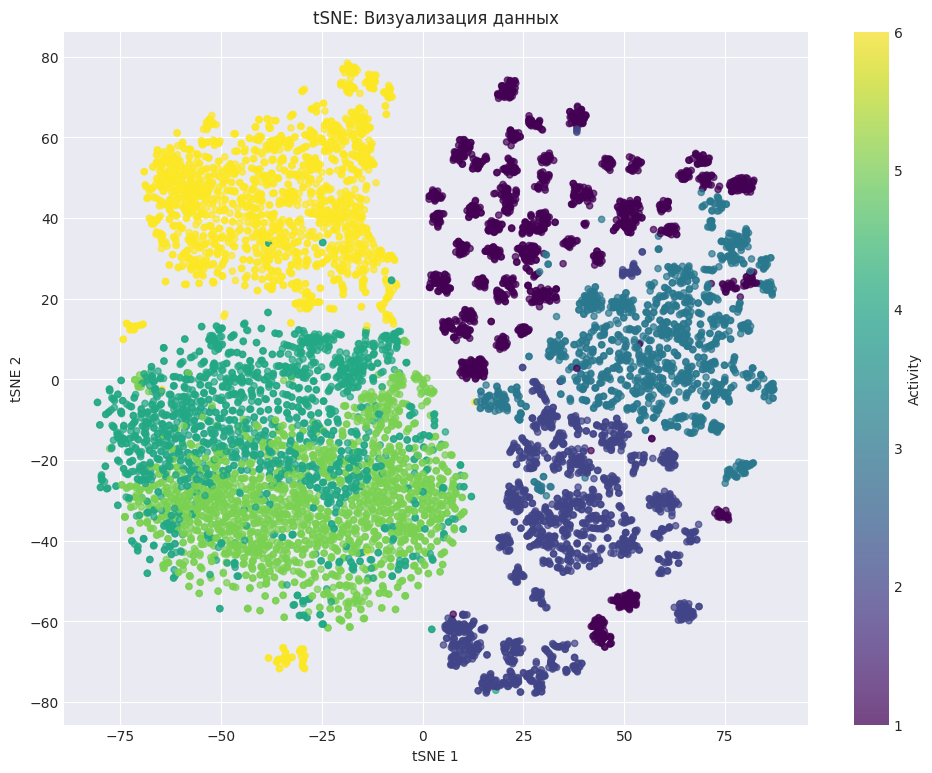

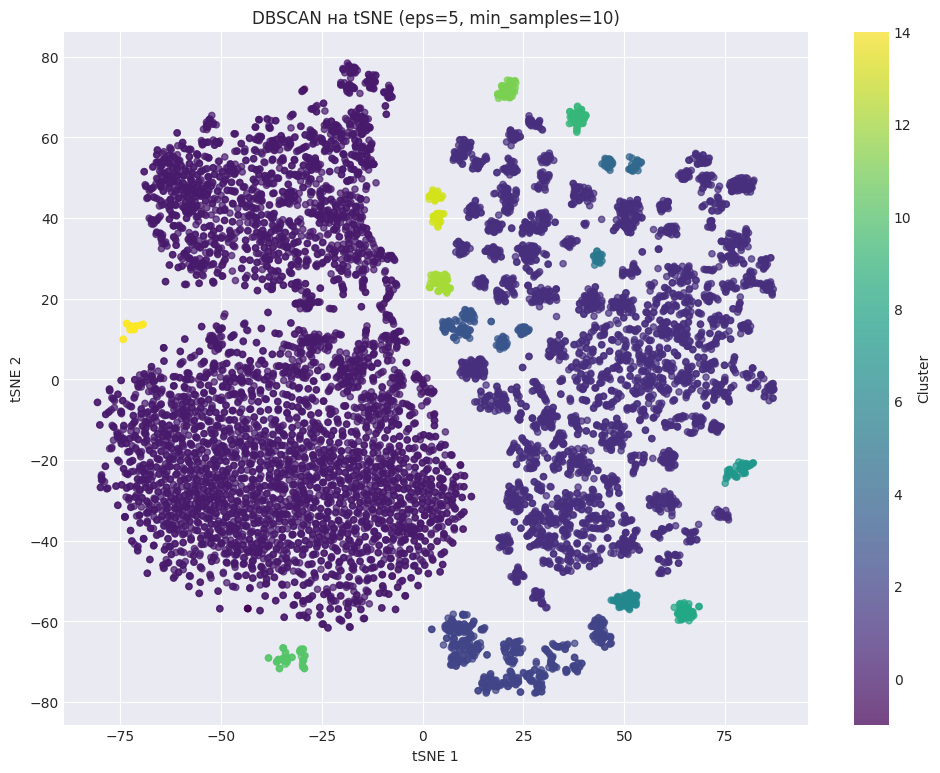

=== Сравнение ===
ARI KMeans на PCA:  0.4198
ARI DBSCAN на tSNE: 0.3148


In [26]:
# tSNE + DBSCAN
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

# tSNE для снижения размерности
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

# Визуализация tSNE
plt.figure(figsize=(12, 9))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, s=20, cmap='viridis', alpha=0.7)
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.title('tSNE: Визуализация данных')
plt.colorbar(label='Activity')
plt.show()

# DBSCAN
dbscan = DBSCAN(eps=5, min_samples=10)
labels_dbscan = dbscan.fit_predict(X_tsne)

# Визуализация DBSCAN
plt.figure(figsize=(12, 9))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_dbscan, s=20, cmap='viridis', alpha=0.7)
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.title('DBSCAN на tSNE (eps=5, min_samples=10)')
plt.colorbar(label='Cluster')
plt.show()

# Сравнение
ari_kmeans_pca = metrics.adjusted_rand_score(y, cluster_labels)
ari_dbscan_tsne = metrics.adjusted_rand_score(y, labels_dbscan)

print("=== Сравнение ===")
print(f"ARI KMeans на PCA:  {ari_kmeans_pca:.4f}")
print(f"ARI DBSCAN на tSNE: {ari_dbscan_tsne:.4f}")